# INFERNO HEP

## 1. Load CMS Open Data

In [1]:
import preproc
import importlib

In [102]:
importlib.reload(preproc)

<module 'preproc' from '/home/centos/dev/pytorch_inferno/experiments/preproc.py'>

In [129]:
#features = ['ht', 'aplanarity', 'sphericity', 'chargeEta', 'MET_met', 'deltaPhiTauMet', 'mt', 'mTauJet']
features = ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
shape_syst = ["06_jes"] #, "taue"]
weight_syst = []#["btag_weight1"]
norm_syst = ["jes_06", "taue", "btag_weight1"]
use_weights = True
mu, qcd, sig_norm = preproc.get_norm(norm_syst)

mu 348.45252731445095
QCD 2689.5053333309675
up 361.5752814461024
nominal 348.45252731445095
down 328.17359646673685
jes_06 16.70084248968277
up 355.0448159528871
nominal 348.45252731445095
down 331.4043246150459
taue 11.82024566892062
up 352.97329592678045
nominal 348.45252731445095
down 343.7486601906056
btag 4.612317868087416


In [130]:
opendata, test_dl, samples, scaler = preproc.load_data( features = features, 
                                                        shape_syst = shape_syst,
                                                        weight_syst = weight_syst,
                                                        norm_syst = norm_syst, 
                                                        bs=bs, n_sig=n_sig, 
                                                        use_weights = use_weights)

*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['06_jes']
Weight systematics []
Use weights True
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
*********************
Summary data
batch size 1000
x torch.Size([4, 3])
y tensor([1.])
w torch.Size([1, 1])
*********************


/home/centos/dev/pytorch_inferno/experiments/preproc.py:158: FutureWarning: The default value of regex will change from True to False in a future version.
  samples["TTJets_signal_" + syst + ud].columns = samples["TTJets_signal_" + syst + ud].columns.str.replace(


## 2. Run HEP-like INFERNO model

In [131]:
import hep_model

In [132]:
importlib.reload(hep_model)

<module 'hep_model' from '/home/centos/dev/pytorch_inferno/experiments/hep_model.py'>

In [133]:
import train

In [134]:
importlib.reload(train)

<module 'train' from '/home/centos/dev/pytorch_inferno/experiments/train.py'>

In [135]:
shape_norm_sigma = [0.05]#, 0.02]
s_norm_sigma = []#[0.05, 0.1]

# Parameters for INFERNO training
inferno_args = {}
# Signal and bkg
inferno_args["b_true"] = qcd
inferno_args["mu_true"] = mu
# Number of shape nuisances
inferno_args["n_shape_systs"] = len(shape_syst)
inferno_args["n_weight_systs"] = 0 #len(weight_syst)
# Constraints on the nuisance parameters - typically should be N(0,1) if +-1sigma templates are provided
inferno_args["shape_norm_sigma"] = shape_norm_sigma
#inferno_args["shape_aux"] = [Normal(0,1) for i in range(len(shape_syst) + len(weight_syst))]
# Uncertainties on signal norm - should be Normal(0,s) with s in absolute event numbers
inferno_args["s_norm_aux"] = sig_norm #[Normal(0,10), Normal(0,10), Normal(0,10)]
# Boolean whether to let the background float
inferno_args["nonaux_b_norm"] = False

train_args = {}
train_args["lr"] = 1e-3
train_args["n_feats"] = len(features)
train_args["neurons"] = 100
train_args["bins"] = 10
train_args["temperature"] = 0.1
train_args["weights"] = False

OUTPATH = "/home/centos/data/inferno_cmsopen13"

bs = 1000
n_sig = 20000
epochs = 200

store = False

In [136]:
importlib.reload(train)
importlib.reload(hep_model)
inferno_model, inferno_info = train.train_inferno(opendata, epochs=5, inferno_args = inferno_args)

*********************
Summary INFERNO setup
b_true 2689.5053333309675
mu_true 348.45252731445095
nshape_alphas 1
shape idx [1]
shape_norm_sigma [0.05]
s_norm_sigma None
s_norm_idxs []
b_norm_sigma None
b_norm_idxs []
b_rate_param False
n_alpha 2
interp_algo default
use_hist False
ignore_loss False
*********************


1: Train=1282.5327197265624 Valid=889.161171875
2: Train=850.29361328125 Valid=845.7975122070312
3: Train=813.5908959960938 Valid=824.5269458007813
4: Train=794.1434301757813 Valid=812.5718896484375
5: Train=776.3803369140625 Valid=794.2554028320312


In [ ]:
importlib.reload(hep_model)
df_inf, order_d = hep_model.pred_test(inferno_model, test_dl, name="inferno")

In [296]:
importlib.reload(plot)

<module 'plot' from '/home/centos/dev/pytorch_inferno/experiments/plot.py'>

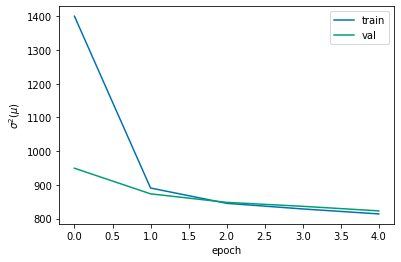

In [297]:
plot.plot_loss(inferno_info["loss"])

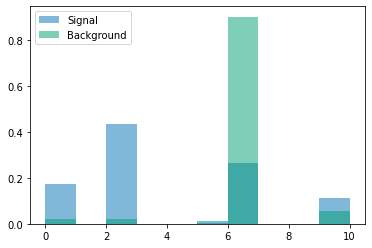

In [298]:
plot.plot_predictions(df_inf, plot_sorted=False, name="inferno")

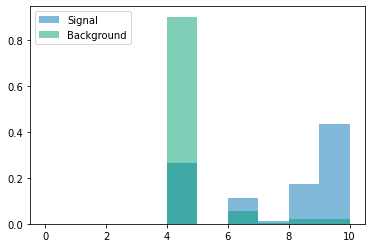

In [299]:
plot.plot_predictions(df_inf, plot_sorted=True, name="inferno")

## 3. Run BCE model

In [290]:
importlib.reload(train)

<module 'train' from '/home/centos/dev/pytorch_inferno/experiments/train.py'>

In [291]:
bce_model, bce_info = train.train_bce(opendata, epochs=5, inferno_args = inferno_args)

*********************
Summary INFERNO setup
b_true 2689.5053333309675
mu_true 348.45252731445095
nshape_alphas 2
shape idx [1, 2]
shape_norm_sigma [0.05, 0.02]
s_norm_sigma []
s_norm_idxs []
b_norm_sigma None
b_norm_idxs []
b_rate_param False
n_alpha 3
interp_algo default
use_hist True
ignore_loss True
*********************


1: Train=0.6548639535903931 Valid=0.6479428815841675
2: Train=0.6240117859840393 Valid=0.6226810693740845
3: Train=0.5902965664863586 Valid=0.5923248338699341
4: Train=0.5495964026451111 Valid=0.5569145727157593
5: Train=0.5049315595626831 Valid=0.5203902637958526


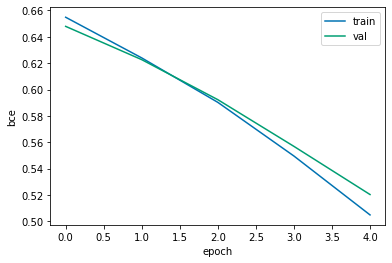

In [292]:
plot.plot_loss(bce_info["loss"], name="bce")

In [300]:
df_bce, _ = hep_model.pred_test(bce_model, test_dl, name="bce")

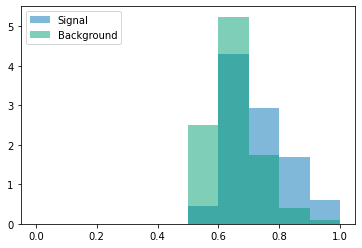

In [301]:
plot.plot_predictions(df_bce, plot_sorted=False, name="bce")

## 4. Plot results

In [20]:
import plot

In [76]:
importlib.reload(plot)

<module 'plot' from '/home/centos/dev/pytorch_inferno/experiments/plot.py'>

In [304]:
inferno_trn_covs, inferno_val_covs = inferno_info["covs"]["trn"], inferno_info["covs"]["val"]
bce_trn_covs, bce_val_covs = bce_info["covs"]["trn"], bce_info["covs"]["val"]

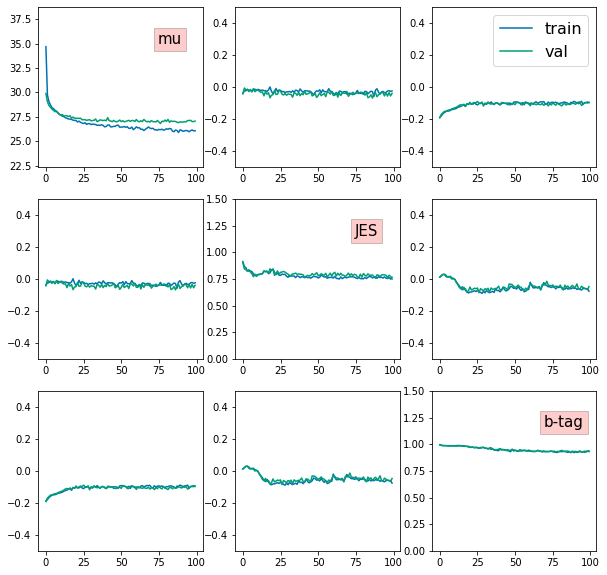

In [145]:
names = ["mu","JES",'b-tag']
plot.plot_cov_trnval(inferno_trn_covs, inferno_val_covs, names, stddev=True)

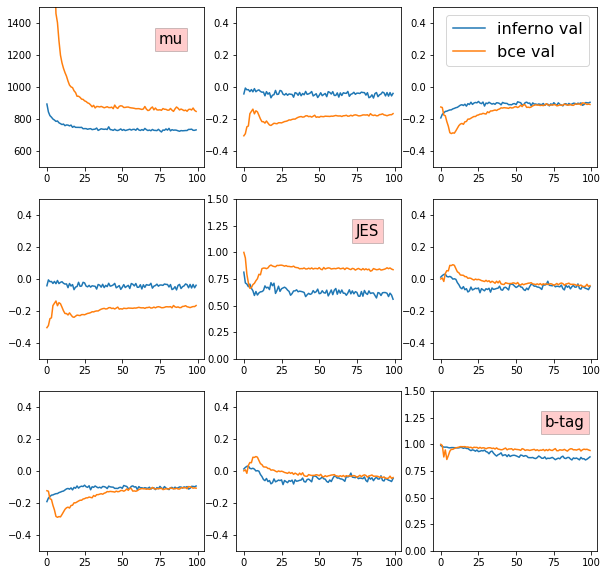

In [74]:
plot.plot_cov_infbce(bce_val_covs, inferno_val_covs, names)

## 5. Predict

In [168]:
importlib.reload(hep_model)

<module 'hep_model' from '/home/centos/dev/pytorch_inferno/experiments/hep_model.py'>

In [169]:
# Predict INFERNO
hep_model.pred_nominal(samples, features, model_inferno, scaler, name='inferno', order_d = order_d)
# Predict BCE
hep_model.pred_nominal(samples, features, model_bce, scaler, name="bce")

## 6. Fit

In [170]:
import fit

In [193]:
importlib.reload(fit)

<module 'fit' from '/home/centos/dev/pytorch_inferno/experiments/fit.py'>

In [194]:
path = "/home/centos/data/inferno_cmsopen13"

In [196]:
fit.to_root(samples, path=path, systs = ["btag", "pdf", "trigger"])

### BCE

In [121]:
import numpy as np
import cabinetry

In [256]:
importlib.reload(fit)
# Create config
bins = np.linspace(0,1,10)
fit_var = "bce"
sample_names = ["Data", "QCD", "TTJets_bkg", "WZJets", "STJets", "TTJets_signal"]
mc = ["TTJets_bkg", "WZJets", "STJets", "TTJets_signal"]
corr_shape_systs = {"TTJets_signal" : ["btag"], "TTJets_bkg" : ["btag"]}
uncorr_shape_systs = {"TTJets_signal" : ["06_jes"]}
norm_syst ={}# {"lumi":{ "samples" : mc, "value" : 0.02 }, }
config = fit.create_config(path, fit_var, bins, sample_names, corr_shape_systs, 
                           uncorr_shape_systs, norm_syst, float_qcd=True)

In [257]:
config

{'General': {'Measurement': 'CMSOpenData',
  'POI': 'Signal_norm',
  'InputPath': '/home/centos/data/inferno_cmsopen13/root_trees/{SamplePath}',
  'HistogramFolder': '/home/centos/data/inferno_cmsopen13/histograms/'},
 'Regions': [{'Name': 'Signal_region',
   'Variable': 'bce',
   'Binning': [0.0,
    0.1111111111111111,
    0.2222222222222222,
    0.3333333333333333,
    0.4444444444444444,
    0.5555555555555556,
    0.6666666666666666,
    0.7777777777777777,
    0.8888888888888888,
    1.0]}],
 'Samples': [{'Name': 'Data',
   'Tree': 'tree',
   'SamplePath': 'Data.root',
   'Data': True},
  {'Name': 'QCD',
   'Tree': 'tree',
   'SamplePath': 'QCD.root',
   'Weight': 'weight'},
  {'Name': 'TTJets_bkg',
   'Tree': 'tree',
   'SamplePath': 'TTJets_bkg.root',
   'Weight': 'weight'},
  {'Name': 'WZJets',
   'Tree': 'tree',
   'SamplePath': 'WZJets.root',
   'Weight': 'weight'},
  {'Name': 'STJets',
   'Tree': 'tree',
   'SamplePath': 'STJets.root',
   'Weight': 'weight'},
  {'Name': 'TT

In [258]:
importlib.reload(fit)

<module 'fit' from '/home/centos/dev/pytorch_inferno/experiments/fit.py'>

In [259]:
ws_path = path + "/workspace_bce.json"
ws = fit.create_ws(config, workspace_path = ws_path)

In [260]:
ws

{'channels': [{'name': 'Signal_region',
   'samples': [{'name': 'QCD',
     'data': [359.7255089133978,
      465.3619240671396,
      356.1474080234766,
      306.2648591399193,
      262.35037426650524,
      251.7934412509203,
      262.88634517788887,
      225.11046873033047,
      201.08245633542538],
     'modifiers': [{'data': None, 'name': 'QCD_norm', 'type': 'normfactor'}]},
    {'name': 'TTJets_bkg',
     'data': [3.896528926678002,
      6.950379027053714,
      8.169310737866908,
      8.68502375879325,
      10.653250739444047,
      12.969360087998211,
      17.346430003410205,
      21.66635628254153,
      43.766763399820775],
     'modifiers': [{'name': 'btag',
       'type': 'normsys',
       'data': {'hi': 1.0139311604324184, 'lo': 0.9855158019886902}},
      {'name': 'btag',
       'type': 'histosys',
       'data': {'hi_data': [3.898467707227564,
         6.955805323720168,
         8.18445349378791,
         8.674186218558772,
         10.651446380862833,
       

W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line


FitResults(bestfit=array([1.00000000e+00, 3.42555845e-14, 1.00000000e+00, 1.51292867e-12]), uncertainty=array([0.02216845, 0.99326736, 0.10053946, 0.96781095]), labels=['QCD_norm', 'btag', 'Signal_norm', 'TTJets_signal_06_jes'], corr_mat=array([[ 1.        , -0.01704888, -0.29087458, -0.18288085],
       [-0.01704888,  1.        , -0.15550844, -0.00276441],
       [-0.29087458, -0.15550844,  1.        , -0.15115335],
       [-0.18288085, -0.00276441, -0.15115335,  1.        ]]), best_twice_nll=73.03045851171905, goodness_of_fit=-1)

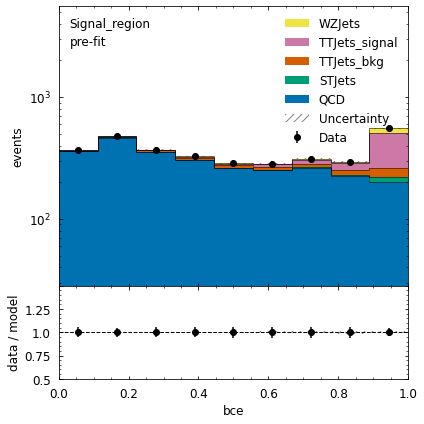

In [262]:
fit.fit_ws(ws, config, asimov=True)

### INFERNO

In [156]:
# Create config
#bins = np.linspace(0,9,9)
bins = np.linspace(0,10,10)
fit_var = "inferno_sorted"
config = fit.create_config(path, fit_var, bins)

In [157]:
ws_path = path + "/workspace_inferno.json"
ws = fit.create_ws(config, workspace_path = ws_path)

Signal_region_WZJets has empty bins: [2]
Signal_region_WZJets has empty bins: [2]


FitResults(bestfit=array([ 0.94841885,  0.80460828, -0.00159314,  1.0234685 ]), uncertainty=array([0.09627255, 0.83434331, 0.99365469, 0.02284498]), labels=['Signal_norm', 'JES', 'btag', 'QCD_norm'], corr_mat=array([[ 1.00000000e+00,  2.08745773e-01, -1.28439064e-01,
        -3.62307478e-01],
       [ 2.08745773e-01,  1.00000000e+00,  2.06108061e-04,
        -2.74480589e-01],
       [-1.28439064e-01,  2.06108061e-04,  1.00000000e+00,
        -1.16348197e-03],
       [-3.62307478e-01, -2.74480589e-01, -1.16348197e-03,
         1.00000000e+00]]), best_twice_nll=64.53875782737408, goodness_of_fit=-1)

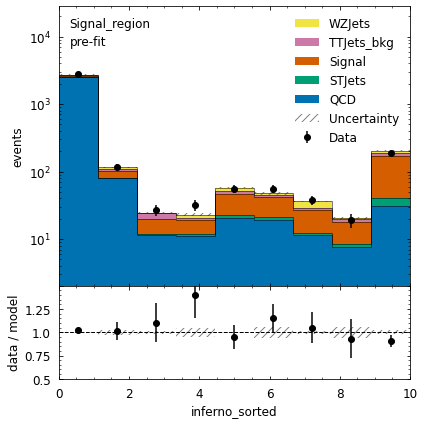

In [158]:
fit.fit_ws(ws, config, asimov=False)